<a href="https://colab.research.google.com/github/AntoineDps/Courses/blob/main/Exercise_10_real_time_noise_rejection_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This exercise is based on the paper https://arxiv.org/pdf/2112.01031.pdf In this exercise you essentially redo section 3 of the paper. 

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

You can estimate how fast a network prediction can be calculated by calculating the number of floating point operations performed in the network. This package is a handy tool to do it:

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

Downloading the data (1 signal data file and 5 noise data files)

In [ ]:
# download data file that contains signal events
!gdown https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq


Downloading...
From: https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq
To: /content/trimmed100_data_signal_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 153MB/s]


In [ ]:
# download data file that contains noise events
!gdown https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
!gdown https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
!gdown https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
!gdown https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
!gdown https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
!gdown https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx

Downloading...
From: https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
To: /content/trimmed100_data_noise_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
To: /content/trimmed100_data_noise_3.6SNR_1ch_0001.npy
100% 80.0M/80.0M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
To: /content/trimmed100_data_noise_3.6SNR_1ch_0002.npy
100% 80.0M/80.0M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
To: /content/trimmed100_data_noise_3.6SNR_1ch_0003.npy
100% 80.0M/80.0M [00:00<00:00, 193MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
To: /content/trimmed100_data_noise_3.6SNR_1ch_0004.npy
100% 80.0M/80.0M [00:00<00:00, 172MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx
To: /cont

Load the data into memory and combine it into one array. 

In [ ]:
# load signal and noise data set into memory
noise = np.load("trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,6):
  noise = np.vstack((noise,np.load(f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
  print(noise.shape)
signal = np.load("trimmed100_data_signal_3.6SNR_1ch_0000.npy")
n_classes = 2

(200000, 100)
(300000, 100)
(400000, 100)
(500000, 100)
(600000, 100)


In [ ]:
# combine noise and signal data set
x = np.vstack((noise, signal))
x = np.reshape(x, (x.shape[0], -1))
# the shape is adjusted to contain two empty dimentions at the end to be able to 
# use 2D convolutions
# x = x[..., np.newaxis, np.newaxis]
x = np.expand_dims(x, axis=-1)  
x = np.expand_dims(x, axis=-1)
print(x.shape)
n_samples = x.shape[1]


# define labels. As we have only two categories, we don't use one-hot encoding
# but "0" for noise and "1" for signal. 
y = np.ones(len(x))
y[:len(noise)] = 0

(699997, 100, 1, 1)


Currently, our training data first contains all noise events and then only signal events. This is not optimal, especially because Keras will pick the last X% of the data set for the validation data (which would mean we train only on noise and then validate with signal, which does not make much sense). Therefore, we randomly shuffle the dataset. Important: The x and y arrays need to be shuffled identicially as in the code below. 

In [ ]:
# shuffel the data
shuffle = np.arange(x.shape[0], dtype=np.int)
np.random.shuffle(shuffle)
x = x[shuffle]
y = y[shuffle]

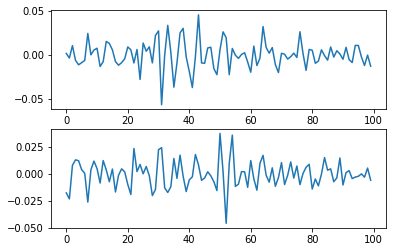

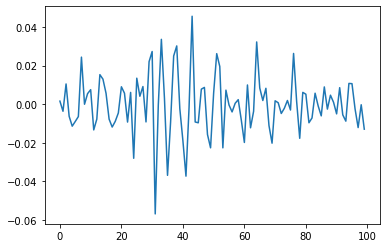

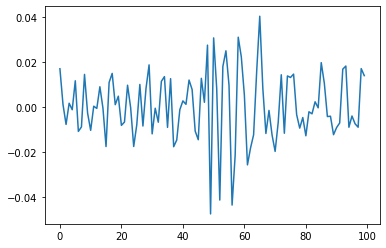

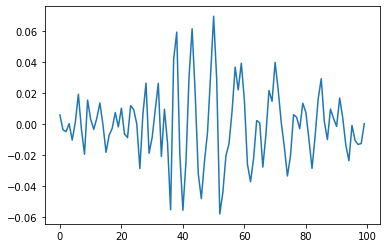

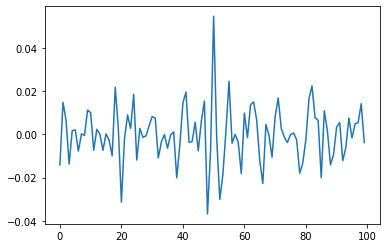

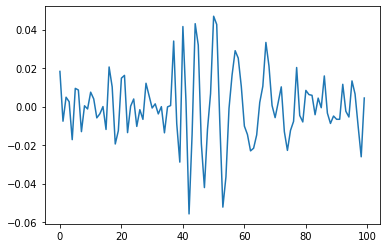

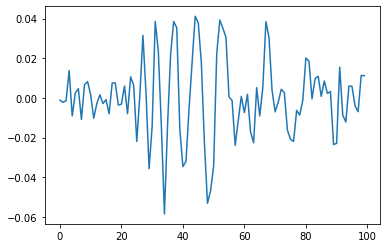

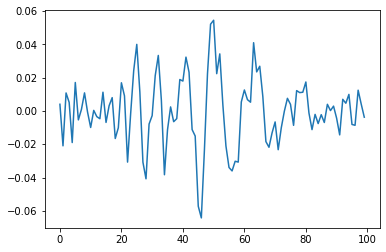

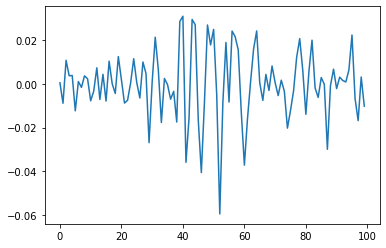

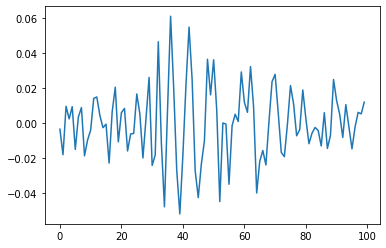

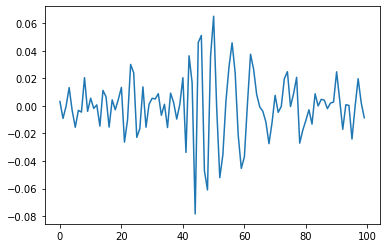

In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(signal[0])
ax[1].plot(noise[0])
plt.show()
for i in range(10):
  fig, ax = plt.subplots(1, 1)
  ax.plot(signal[i])
  plt.show()

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
]

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(5, (10, 1), activation='relu', input_shape=(n_samples, 1, 1)))  # n_filters, n_width
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling2D(pool_size=(10, 1)))
model_cnn.add(Flatten())  
model_cnn.add(Dense(1, activation='sigmoid'))
print(model_cnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 91, 1, 5)          55        
                                                                 
 dropout_1 (Dropout)         (None, 91, 1, 5)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 1, 5)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 45)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 46        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
________________________________________________________

In [ ]:
flops = get_flops(model_cnn)
print(f"number of floating point operations {flops:.3g}")

number of floating point operations 1.01e+04


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model_cnn.compile(optimizer=opt,
          loss='binary_crossentropy',
          metrics=['accuracy'])

In [ ]:
model_cnn.fit(x,
          y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=callbacks_list,
          validation_split=0.2,
          verbose=1)

Epoch 1/50
17500/17500 [==============================] - 87s 5ms/step - loss: 0.1386 - accuracy: 0.9521 - val_loss: 0.2052 - val_accuracy: 0.9722
Epoch 2/50
17500/17500 [==============================] - 86s 5ms/step - loss: 0.0608 - accuracy: 0.9818 - val_loss: 0.1743 - val_accuracy: 0.9697
Epoch 3/50
17500/17500 [==============================] - 86s 5ms/step - loss: 0.0557 - accuracy: 0.9831 - val_loss: 0.1645 - val_accuracy: 0.9696
Epoch 4/50
17500/17500 [==============================] - 89s 5ms/step - loss: 0.0532 - accuracy: 0.9840 - val_loss: 0.1408 - val_accuracy: 0.9771
Epoch 5/50
17500/17500 [==============================] - 90s 5ms/step - loss: 0.0515 - accuracy: 0.9846 - val_loss: 0.1464 - val_accuracy: 0.9751
Epoch 6/50
17500/17500 [==============================] - 90s 5ms/step - loss: 0.0503 - accuracy: 0.9852 - val_loss: 0.1493 - val_accuracy: 0.9739
Epoch 7/50
17500/17500 [==============================] - 91s 5ms/step - loss: 0.0497 - accuracy: 0.9855 - val_loss: 0

Now we load back in the best performing model and calculate the prediction. 

In [ ]:
model_cnn = keras.models.load_model('best_model.h5')
# plot signal efficiency vs. noise rejection
y_pred = model_cnn.predict(x)
print(y_pred)

[[0.08166789]
 [0.20745783]
 [0.20898184]
 ...
 [0.9997738 ]
 [1.        ]
 [0.02329389]]


Let's visualize the neural network output for the signal and noise data sets in a histogram. We can see that the two distributions are significantly distinct. 

(array([4.69573e+05, 8.39140e+04, 2.53600e+04, 1.05900e+04, 5.12200e+03,
        2.71900e+03, 1.49700e+03, 7.27000e+02, 3.83000e+02, 1.15000e+02]),
 array([0.01463233, 0.11209749, 0.20956266, 0.30702782, 0.404493  ,
        0.50195813, 0.59942335, 0.6968885 , 0.79435366, 0.8918188 ,
        0.989284  ], dtype=float32),
 <a list of 10 Patch objects>)

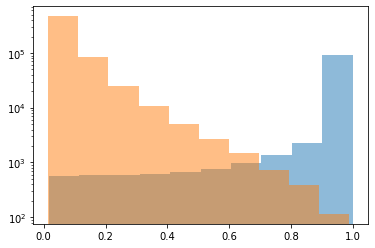

In [ ]:
smask = y == 1
plt.hist(y_pred[smask], log=True, alpha=0.5)
plt.hist(y_pred[~smask], log=True, alpha=0.5)

The signal efficiency and noise rejection rate depends on the exact threshold that is applied to the neural network output. Here, we scan through all possible threshold values from .1 to 0.999, calculate the signal efficiency and noise rejection and plot the results. 

In [ ]:
yy = np.linspace(0.1, 0.99999, 1000)
n = np.zeros_like(yy)
s = np.zeros_like(yy)
for iT, threshold in enumerate(yy):
    eff_signal = np.sum((y_pred[smask] > threshold) == True) / len(signal)
    s[iT] = eff_signal
    eff_noise = np.sum((y_pred[~smask] <= threshold) == True) / len(noise)
    if(eff_noise < 1):
        reduction_factor = 1 / (1 - eff_noise)
    else:
        reduction_factor = len(noise)
    n[iT] = reduction_factor


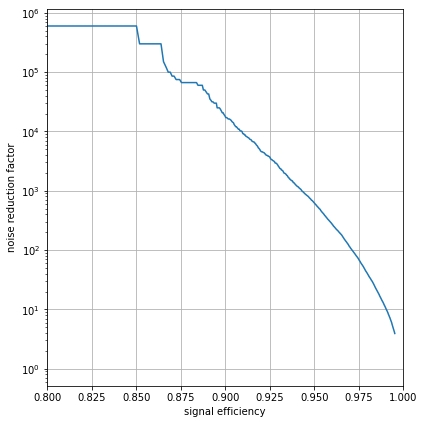

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(s, n)
ax.set_xlabel("signal efficiency")
ax.set_ylabel("noise reduction factor")
ax.semilogy(True)
ax.set_xlim(.8,1)
ax.grid(1)
fig.tight_layout()
plt.show()